# Análise de Latência e Saltos - IPv4 vs IPv6

Este notebook analisa as medições de rede coletadas, comparando latência e número de saltos entre IPv4 e IPv6 para diferentes destinos, países e continentes.

In [31]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

import warnings
from IPython.display import display
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

## 1. Carregamento e Preparação dos Dados

In [32]:
probes_df = pd.read_csv('csvs/probes.csv')
countries_df = pd.read_csv('csvs/countries.csv')
services_df = pd.read_csv('csvs/services.csv')

# mapeamento país : continente
continent_map = {}
for _, row in countries_df.iterrows():
    countries = [c.strip() for c in row['countries'].split(';')]
    for country in countries:
        continent_map[country] = row['continent']

print(f"Carregados dados de {len(probes_df)} probes")
print(f"Mapeamento de {len(continent_map)} países para continentes")
print(f"Serviços analisados: {list(services_df['service'])}")

Carregados dados de 21 probes
Mapeamento de 15 países para continentes
Serviços analisados: ['pypi.org', 'npmjs.com', 'crates.io']


In [33]:
def load_measurement_data(file_path):
    """Carrega e processa dados de medição de um arquivo JSON"""
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    measurements = []
    
    for measurement in data:
        record = {
            'src_addr': measurement.get('src_addr'),
            'dst_name': measurement.get('dst_name'),
            'dst_addr': measurement.get('dst_addr'),
            'endtime': measurement.get('endtime'),
            'af': measurement.get('af'),  # 4 para IPv4, 6 para IPv6
            'ttr': measurement.get('ttr'),
            'fw': measurement.get('fw'),  # firewall ?
            'prb_id': measurement.get('prb_id') # id do probe
        }
        
        
        result = measurement.get('result', [])
        if result:
            # Calcula latencias
            all_rtts = []
            hop_count = len(result)
            
            for hop in result:
                hop_results = hop.get('result', [])
                for hop_result in hop_results:
                    if 'rtt' in hop_result:
                        all_rtts.append(hop_result['rtt'])
            
            if all_rtts:
                record.update({
                    'avg_rtt': np.mean(all_rtts),
                    'min_rtt': np.min(all_rtts),
                    'max_rtt': np.max(all_rtts),
                    'std_rtt': np.std(all_rtts),
                    'hop_count': hop_count,
                    'total_packets': len(all_rtts)
                })
                
                measurements.append(record)
    
    return pd.DataFrame(measurements)

# Carregar todos os arquivos de medição
files = {
    'crates_ipv4': 'corrected_measurements/correct_crates_ipv4.json',
    'crates_ipv6': 'corrected_measurements/correct_crates_ipv6.json',
    'npmjs_ipv4': 'corrected_measurements/correct_npmjs_ipv4.json',
    'npmjs_ipv6': 'corrected_measurements/correct_npmjs_ipv6.json',
    'pypi_ipv4': 'corrected_measurements/correct_pypi_ipv4.json',
    'pypi_ipv6': 'corrected_measurements/correct_pypi_ipv6.json'
}

all_data = []

for name, file_path in files.items():
    try:
        df = load_measurement_data(file_path)
        service = name.split('_')[0]
        ip_version = name.split('_')[1]
        df['service'] = service
        df['ip_version'] = ip_version
        all_data.append(df)
        print(f"Carregado {name}: {len(df)} medições")
    except Exception as e:
        print(f"Erro ao carregar {name}: {e}")


combined_df = pd.concat(all_data, ignore_index=True)

# Adicionar informações de país e continente
probe_country_map = dict(zip(probes_df['probe_id'], probes_df['country']))
display(combined_df)
combined_df['country'] = combined_df['prb_id'].map(probe_country_map)
combined_df['continent'] = combined_df['country'].map(continent_map)
combined_df['datetime'] = pd.to_datetime(combined_df['endtime'], unit='s')

print(f"\nTotal de medições processadas: {len(combined_df)}")
print(f"Serviços: {combined_df['service'].unique()}")
print(f"Versões IP: {combined_df['ip_version'].unique()}")
print(f"Países: {combined_df['country'].nunique()}")
print(f"Continentes: {combined_df['continent'].nunique()}")

Carregado crates_ipv4: 406 medições
Carregado crates_ipv6: 458 medições
Carregado npmjs_ipv4: 398 medições
Carregado npmjs_ipv6: 387 medições
Carregado pypi_ipv4: 381 medições
Carregado pypi_ipv6: 462 medições


,src_addr,dst_name,dst_addr,endtime,af,ttr,fw,prb_id,avg_rtt,min_rtt,max_rtt,std_rtt,hop_count,total_packets,service,ip_version
0,86.45.161.220,crates.io,18.66.171.70,1752991283,4,142.178478,5080,1000929,6.041667,4.344,10.684,1.838107,9,12,crates,ipv4
1,192.168.31.4,crates.io,18.155.88.102,1752991247,4,124.675179,5110,1003179,1.671762,0.313,2.598,0.571700,9,21,crates,ipv4
2,43.228.174.197,crates.io,143.204.80.33,1752991288,4,34.555957,5100,1009516,13.569000,0.296,30.762,11.514187,11,18,crates,ipv4
3,31.13.248.208,crates.io,52.84.106.105,1752991296,4,124.880462,5100,1010523,6.838600,0.278,12.457,5.646582,9,10,crates,ipv4
4,192.168.0.246,crates.io,18.155.107.70,1752991274,4,45.782125,5110,1010721,41.815095,0.431,210.717,68.582285,11,21,crates,ipv4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2487,2401:2520:207a:0:be24:11ff:fe13:a9be,pypi.org,2a04:4e42:200::223,1753074210,6,14.303744,5110,1003179,4.733296,0.157,15.021,5.448632,9,27,pypi,ipv6
2488,2001:df3:14c0:e051::1,pypi.org,2a04:4e42:400::223,1753074204,6,0.779102,5100,1009516,36.218704,0.317,62.761,27.307374,9,27,pypi,ipv6
2489,2605:e440:21::2b6,pypi.org,2a04:4e42::223,1753074211,6,1.716964,5100,1010523,0.648900,0.299,1.765,0.517321,4,10,pypi,ipv6
2490,2800:270:c::126,pypi.org,2a04:4e42:400::223,1753074187,6,0.831573,5080,30100,3.232100,0.349,14.368,2.425306,10,30,pypi,ipv6



Total de medições processadas: 2492
Serviços: ['crates' 'npmjs' 'pypi']
Versões IP: ['ipv4' 'ipv6']
Países: 20
Continentes: 5


## 2. Análise de Latência

### 2.1 Variação da Latência ao Longo do Tempo

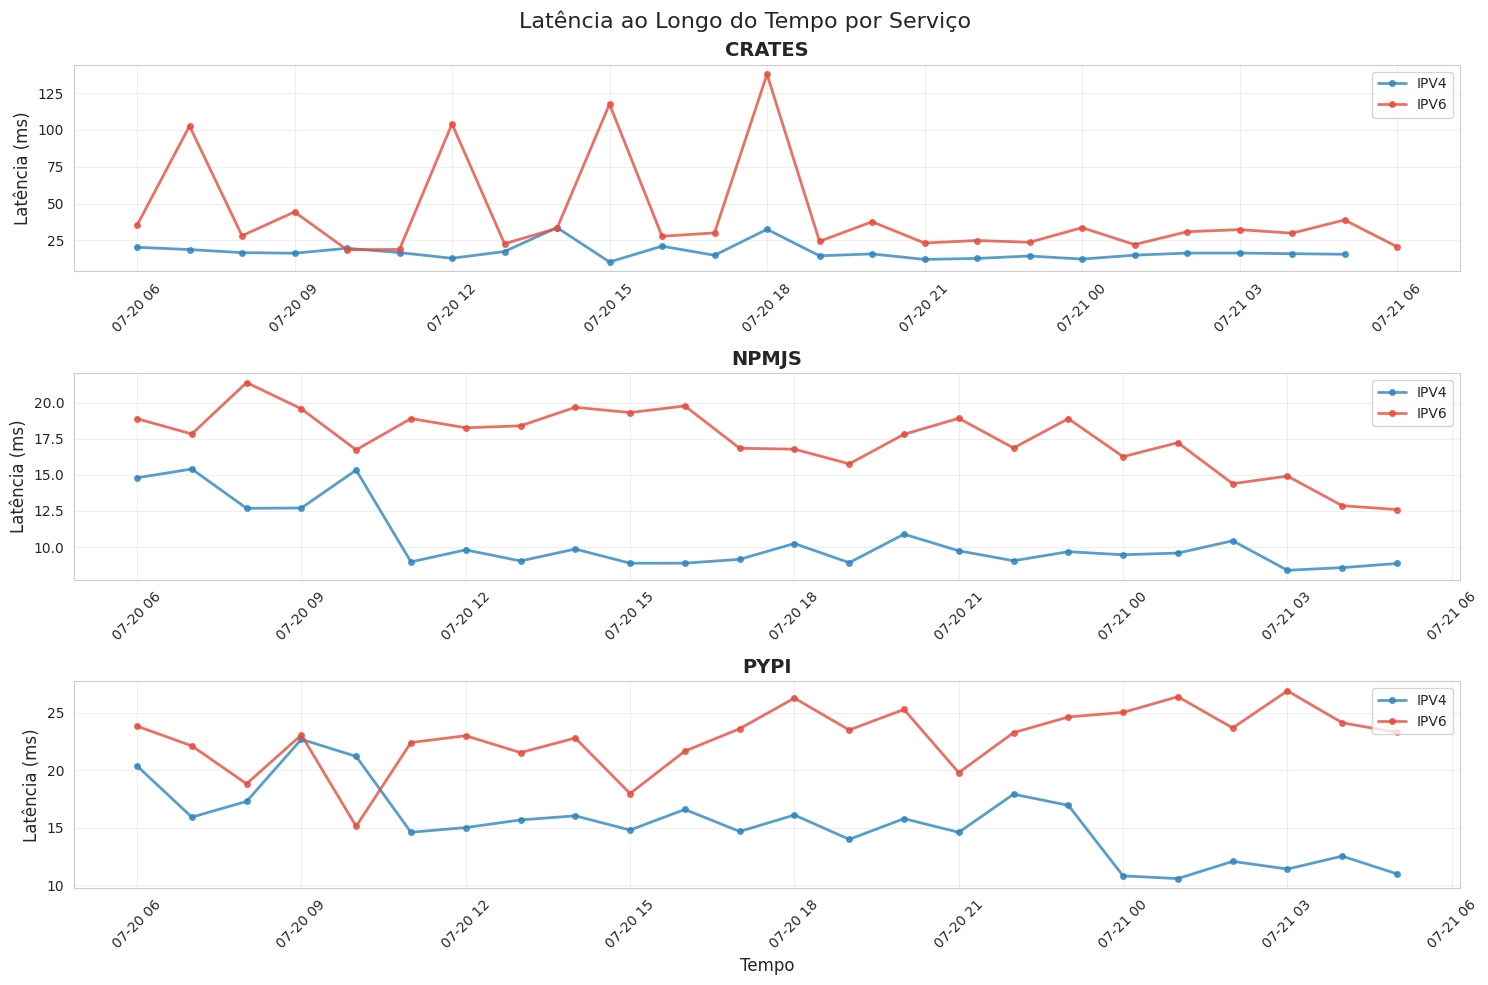

=== RESUMO DE LATÊNCIA POR SERVIÇO ===

CRATES:
  IPV4: 17.3ms (±27.6)
  IPV6: 43.0ms (±159.3)

NPMJS:
  IPV4: 10.6ms (±10.2)
  IPV6: 17.6ms (±23.1)

PYPI:
  IPV4: 15.7ms (±20.4)
  IPV6: 23.0ms (±25.2)


In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
fig.suptitle('Latência ao Longo do Tempo por Serviço', fontsize=16)

services = combined_df['service'].unique()
colors = ['#2E86C1', '#E74C3C']  # Blue for IPv4, Red for IPv6

for i, service in enumerate(services):
    service_data = combined_df[combined_df['service'] == service]
    
    # Group by IP version
    service_data_clean = service_data.copy()
    service_data_clean['hour'] = service_data_clean['datetime'].dt.floor('H')
    hourly_avg = service_data_clean.groupby(['hour', 'ip_version'])['avg_rtt'].mean().reset_index()
    

    for j, ip_version in enumerate(['ipv4', 'ipv6']):
        version_data = hourly_avg[hourly_avg['ip_version'] == ip_version]
        axes[i].plot(version_data['hour'], version_data['avg_rtt'], 
                    color=colors[j], linewidth=2, marker='o', markersize=4,
                    label=ip_version.upper(), alpha=0.8)
    
    axes[i].set_title(f'{service.upper()}', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Latência (ms)', fontsize=12)
    axes[i].legend(loc='upper right')
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

axes[-1].set_xlabel('Tempo', fontsize=12)
plt.tight_layout()
plt.show()

# Resumo
print("=== RESUMO DE LATÊNCIA POR SERVIÇO ===")
for service in services:
    service_data = combined_df[combined_df['service'] == service]
    print(f"\n{service.upper()}:")
    
    for ip_version in ['ipv4', 'ipv6']:
        data = service_data[service_data['ip_version'] == ip_version]['avg_rtt']
        if not data.empty:
            print(f"  {ip_version.upper()}: {data.mean():.1f}ms (±{data.std():.1f})")

### 2.2 Comparação IPv4 vs IPv6 por Destino

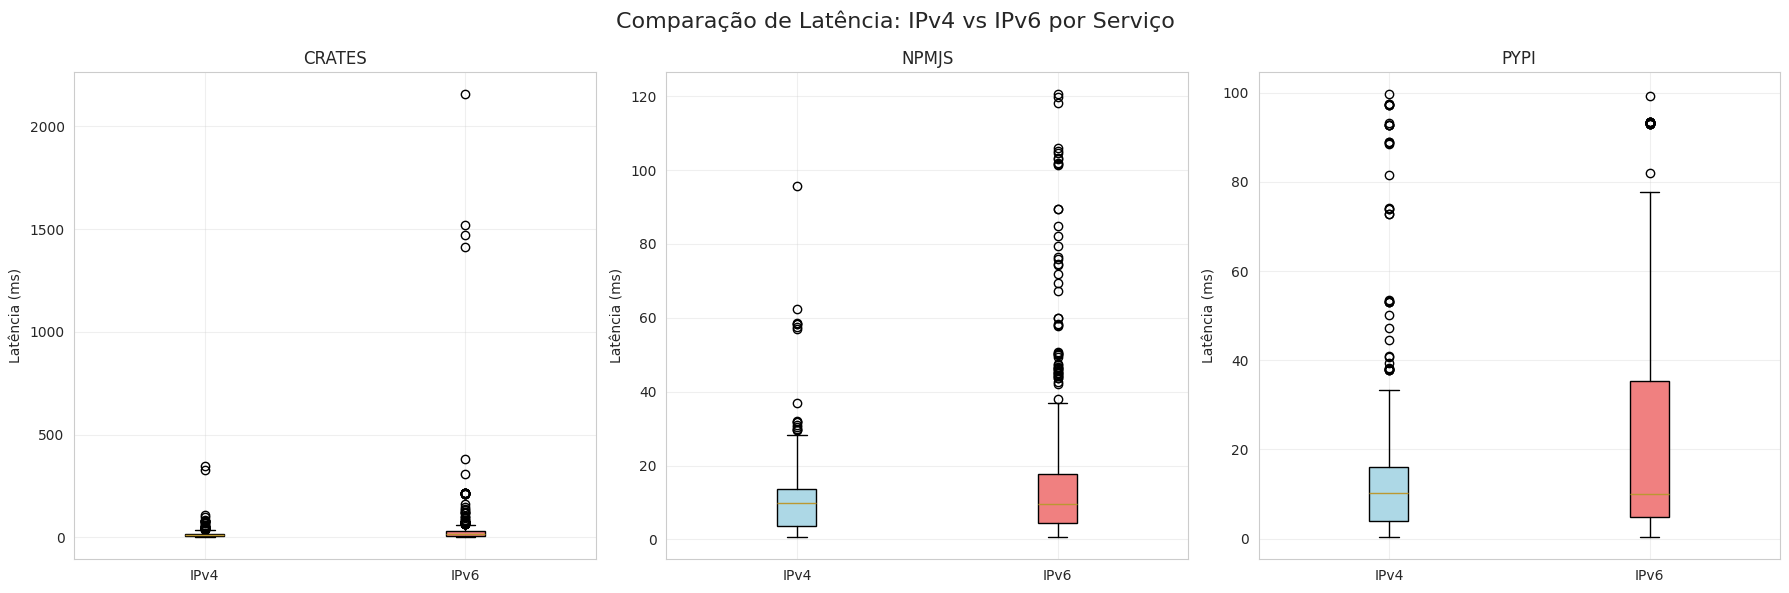

Estatísticas de Latência por Serviço e Versão IP:

CRATES:
IPv4 - Média: 17.30ms, Mediana: 11.31ms
IPv6 - Média: 43.04ms, Mediana: 15.58ms
Diferença percentual (IPv6 vs IPv4): +148.7%

NPMJS:
IPv4 - Média: 10.58ms, Mediana: 9.88ms
IPv6 - Média: 17.61ms, Mediana: 9.51ms
Diferença percentual (IPv6 vs IPv4): +66.4%

PYPI:
IPv4 - Média: 15.73ms, Mediana: 10.33ms
IPv6 - Média: 22.97ms, Mediana: 9.98ms
Diferença percentual (IPv6 vs IPv4): +46.0%


In [35]:
# Comparação IPv4 vs IPv6
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Comparação de Latência: IPv4 vs IPv6 por Serviço', fontsize=16)

for i, service in enumerate(services):
    service_data = combined_df[combined_df['service'] == service]
    
    # Create box plots comparing IPv4 vs IPv6
    ipv4_latencies = service_data[service_data['ip_version'] == 'ipv4']['avg_rtt'].dropna()
    ipv6_latencies = service_data[service_data['ip_version'] == 'ipv6']['avg_rtt'].dropna()
    
    box_data = [ipv4_latencies, ipv6_latencies]
    labels = ['IPv4', 'IPv6']
    
    bp = axes[i].boxplot(box_data, labels=labels, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    axes[i].set_title(f'{service.upper()}')
    axes[i].set_ylabel('Latência (ms)')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


print("Estatísticas de Latência por Serviço e Versão IP:")
print("="*60)

for service in services:
    print(f"\n{service.upper()}:")
    service_data = combined_df[combined_df['service'] == service]
    
    ipv4_stats = service_data[service_data['ip_version'] == 'ipv4']['avg_rtt'].describe()
    ipv6_stats = service_data[service_data['ip_version'] == 'ipv6']['avg_rtt'].describe()
    
    print(f"IPv4 - Média: {ipv4_stats['mean']:.2f}ms, Mediana: {ipv4_stats['50%']:.2f}ms")
    print(f"IPv6 - Média: {ipv6_stats['mean']:.2f}ms, Mediana: {ipv6_stats['50%']:.2f}ms")
    
    
    if ipv4_stats['mean'] > 0:
        diff_pct = ((ipv6_stats['mean'] - ipv4_stats['mean']) / ipv4_stats['mean']) * 100
        print(f"Diferença percentual (IPv6 vs IPv4): {diff_pct:+.1f}%")

### 2.3 Análise por País

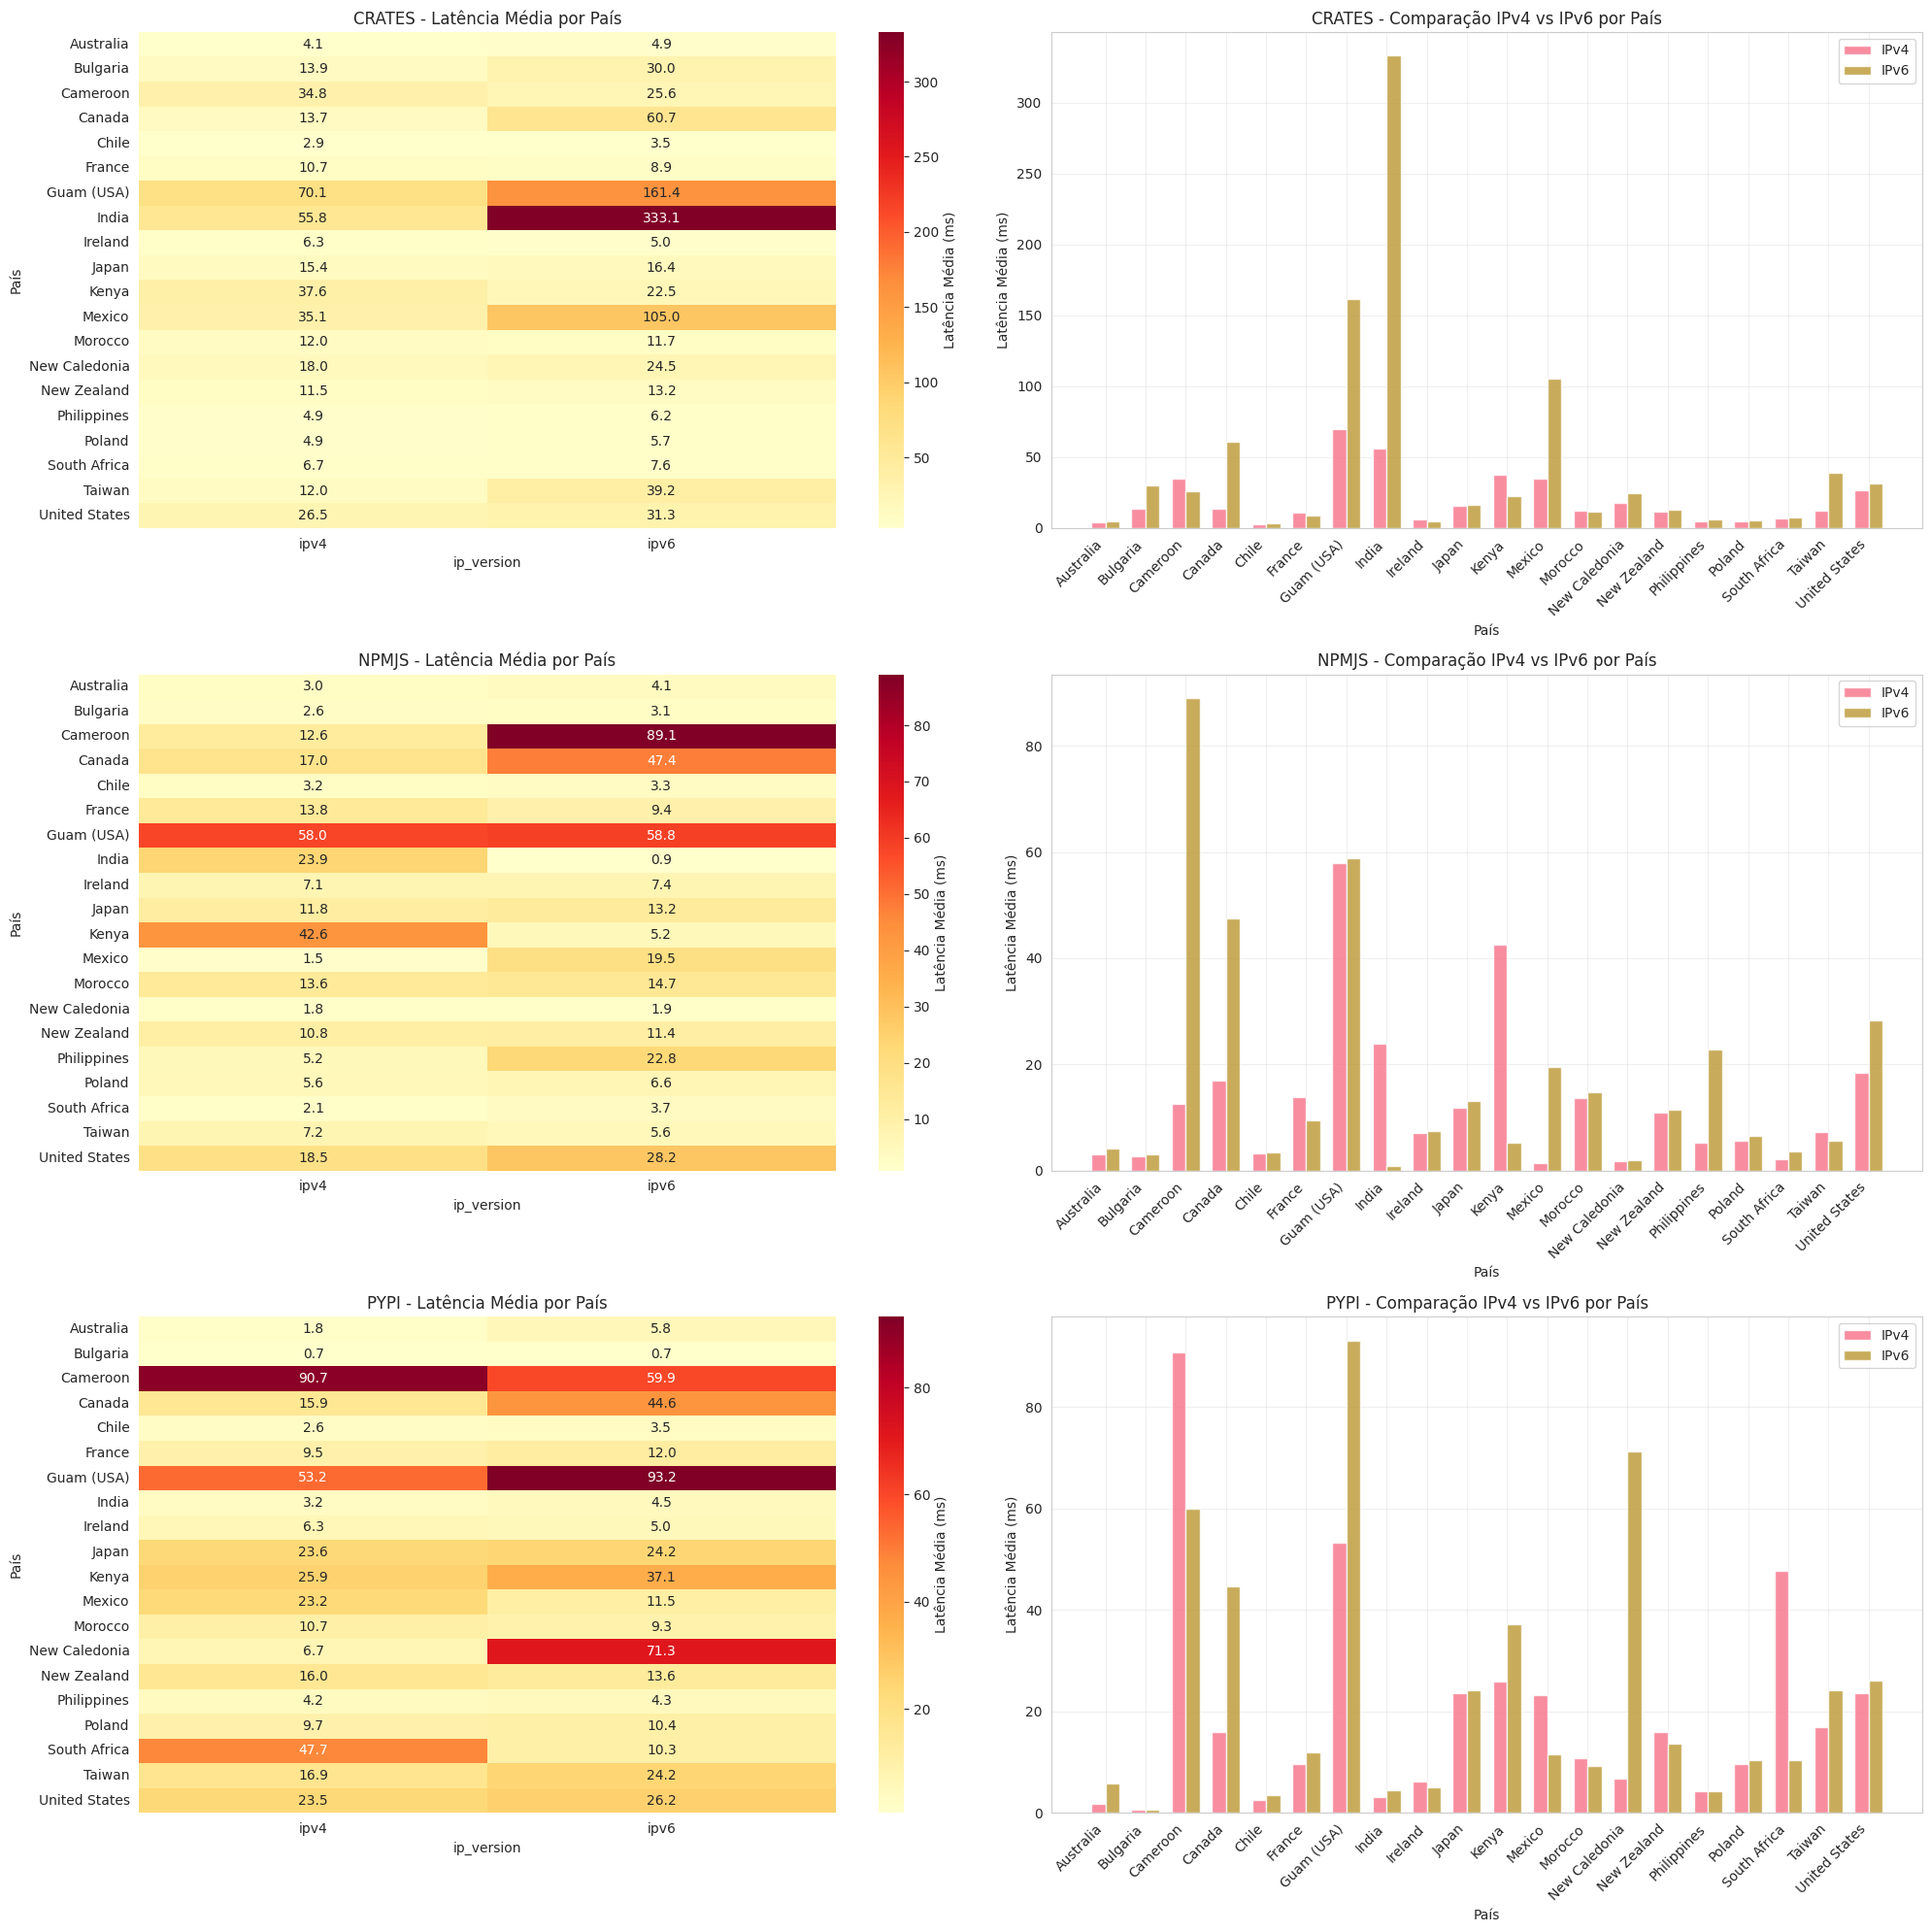

Análise de Latência por País:

CRATES:
IPv4 - Melhor: Chile (2.9ms)
IPv4 - Pior: Guam (USA) (70.1ms)
IPv6 - Melhor: Chile (3.5ms)
IPv6 - Pior: India (333.1ms)

NPMJS:
IPv4 - Melhor: Mexico (1.5ms)
IPv4 - Pior: Guam (USA) (58.0ms)
IPv6 - Melhor: India (0.9ms)
IPv6 - Pior: Cameroon (89.1ms)

PYPI:
IPv4 - Melhor: Bulgaria (0.7ms)
IPv4 - Pior: Cameroon (90.7ms)
IPv6 - Melhor: Bulgaria (0.7ms)
IPv6 - Pior: Guam (USA) (93.2ms)


In [36]:
# Análise Agregada por País - Estilo t.ipynb
# Calculate average latency by country and IP version
country_latency = combined_df.groupby(['country', 'ip_version', 'service'])['avg_rtt'].agg(['mean', 'std', 'count']).reset_index()

plt.figure(figsize=(20, 20))

# Create heatmap for each service
for i, service in enumerate(services):
    plt.subplot(3, 2, i*2 + 1)
    
    service_data = country_latency[country_latency['service'] == service]
    pivot_data = service_data.pivot(index='country', columns='ip_version', values='mean')
    
    sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='YlOrRd', 
                cbar_kws={'label': 'Latência Média (ms)'})
    plt.title(f'{service.upper()} - Latência Média por País')
    plt.ylabel('País')
    
    # Bar plot comparison
    plt.subplot(3, 2, i*2 + 2)
    
    # Prepare data for grouped bar plot
    countries = service_data['country'].unique()
    ipv4_values = []
    ipv6_values = []
    
    for country in countries:
        ipv4_val = service_data[(service_data['country'] == country) & 
                               (service_data['ip_version'] == 'ipv4')]['mean'].values
        ipv6_val = service_data[(service_data['country'] == country) & 
                               (service_data['ip_version'] == 'ipv6')]['mean'].values
        
        ipv4_values.append(ipv4_val[0] if len(ipv4_val) > 0 else 0)
        ipv6_values.append(ipv6_val[0] if len(ipv6_val) > 0 else 0)
    
    x = np.arange(len(countries))
    width = 0.35
    
    plt.bar(x - width/2, ipv4_values, width, label='IPv4', alpha=0.8)
    plt.bar(x + width/2, ipv6_values, width, label='IPv6', alpha=0.8)
    
    plt.xlabel('País')
    plt.ylabel('Latência Média (ms)')
    plt.title(f'{service.upper()} - Comparação IPv4 vs IPv6 por País')
    plt.xticks(x, countries, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print top and bottom performing countries - Estilo t.ipynb
print("Análise de Latência por País:")
print("="*50)

for service in services:
    print(f"\n{service.upper()}:")
    service_data = country_latency[country_latency['service'] == service]
    
    # Best and worst performing countries for IPv4
    ipv4_data = service_data[service_data['ip_version'] == 'ipv4'].sort_values('mean')
    if not ipv4_data.empty:
        print(f"IPv4 - Melhor: {ipv4_data.iloc[0]['country']} ({ipv4_data.iloc[0]['mean']:.1f}ms)")
        print(f"IPv4 - Pior: {ipv4_data.iloc[-1]['country']} ({ipv4_data.iloc[-1]['mean']:.1f}ms)")
    
    # Best and worst performing countries for IPv6
    ipv6_data = service_data[service_data['ip_version'] == 'ipv6'].sort_values('mean')
    if not ipv6_data.empty:
        print(f"IPv6 - Melhor: {ipv6_data.iloc[0]['country']} ({ipv6_data.iloc[0]['mean']:.1f}ms)")
        print(f"IPv6 - Pior: {ipv6_data.iloc[-1]['country']} ({ipv6_data.iloc[-1]['mean']:.1f}ms)")

### 2.4 Análise por Continente

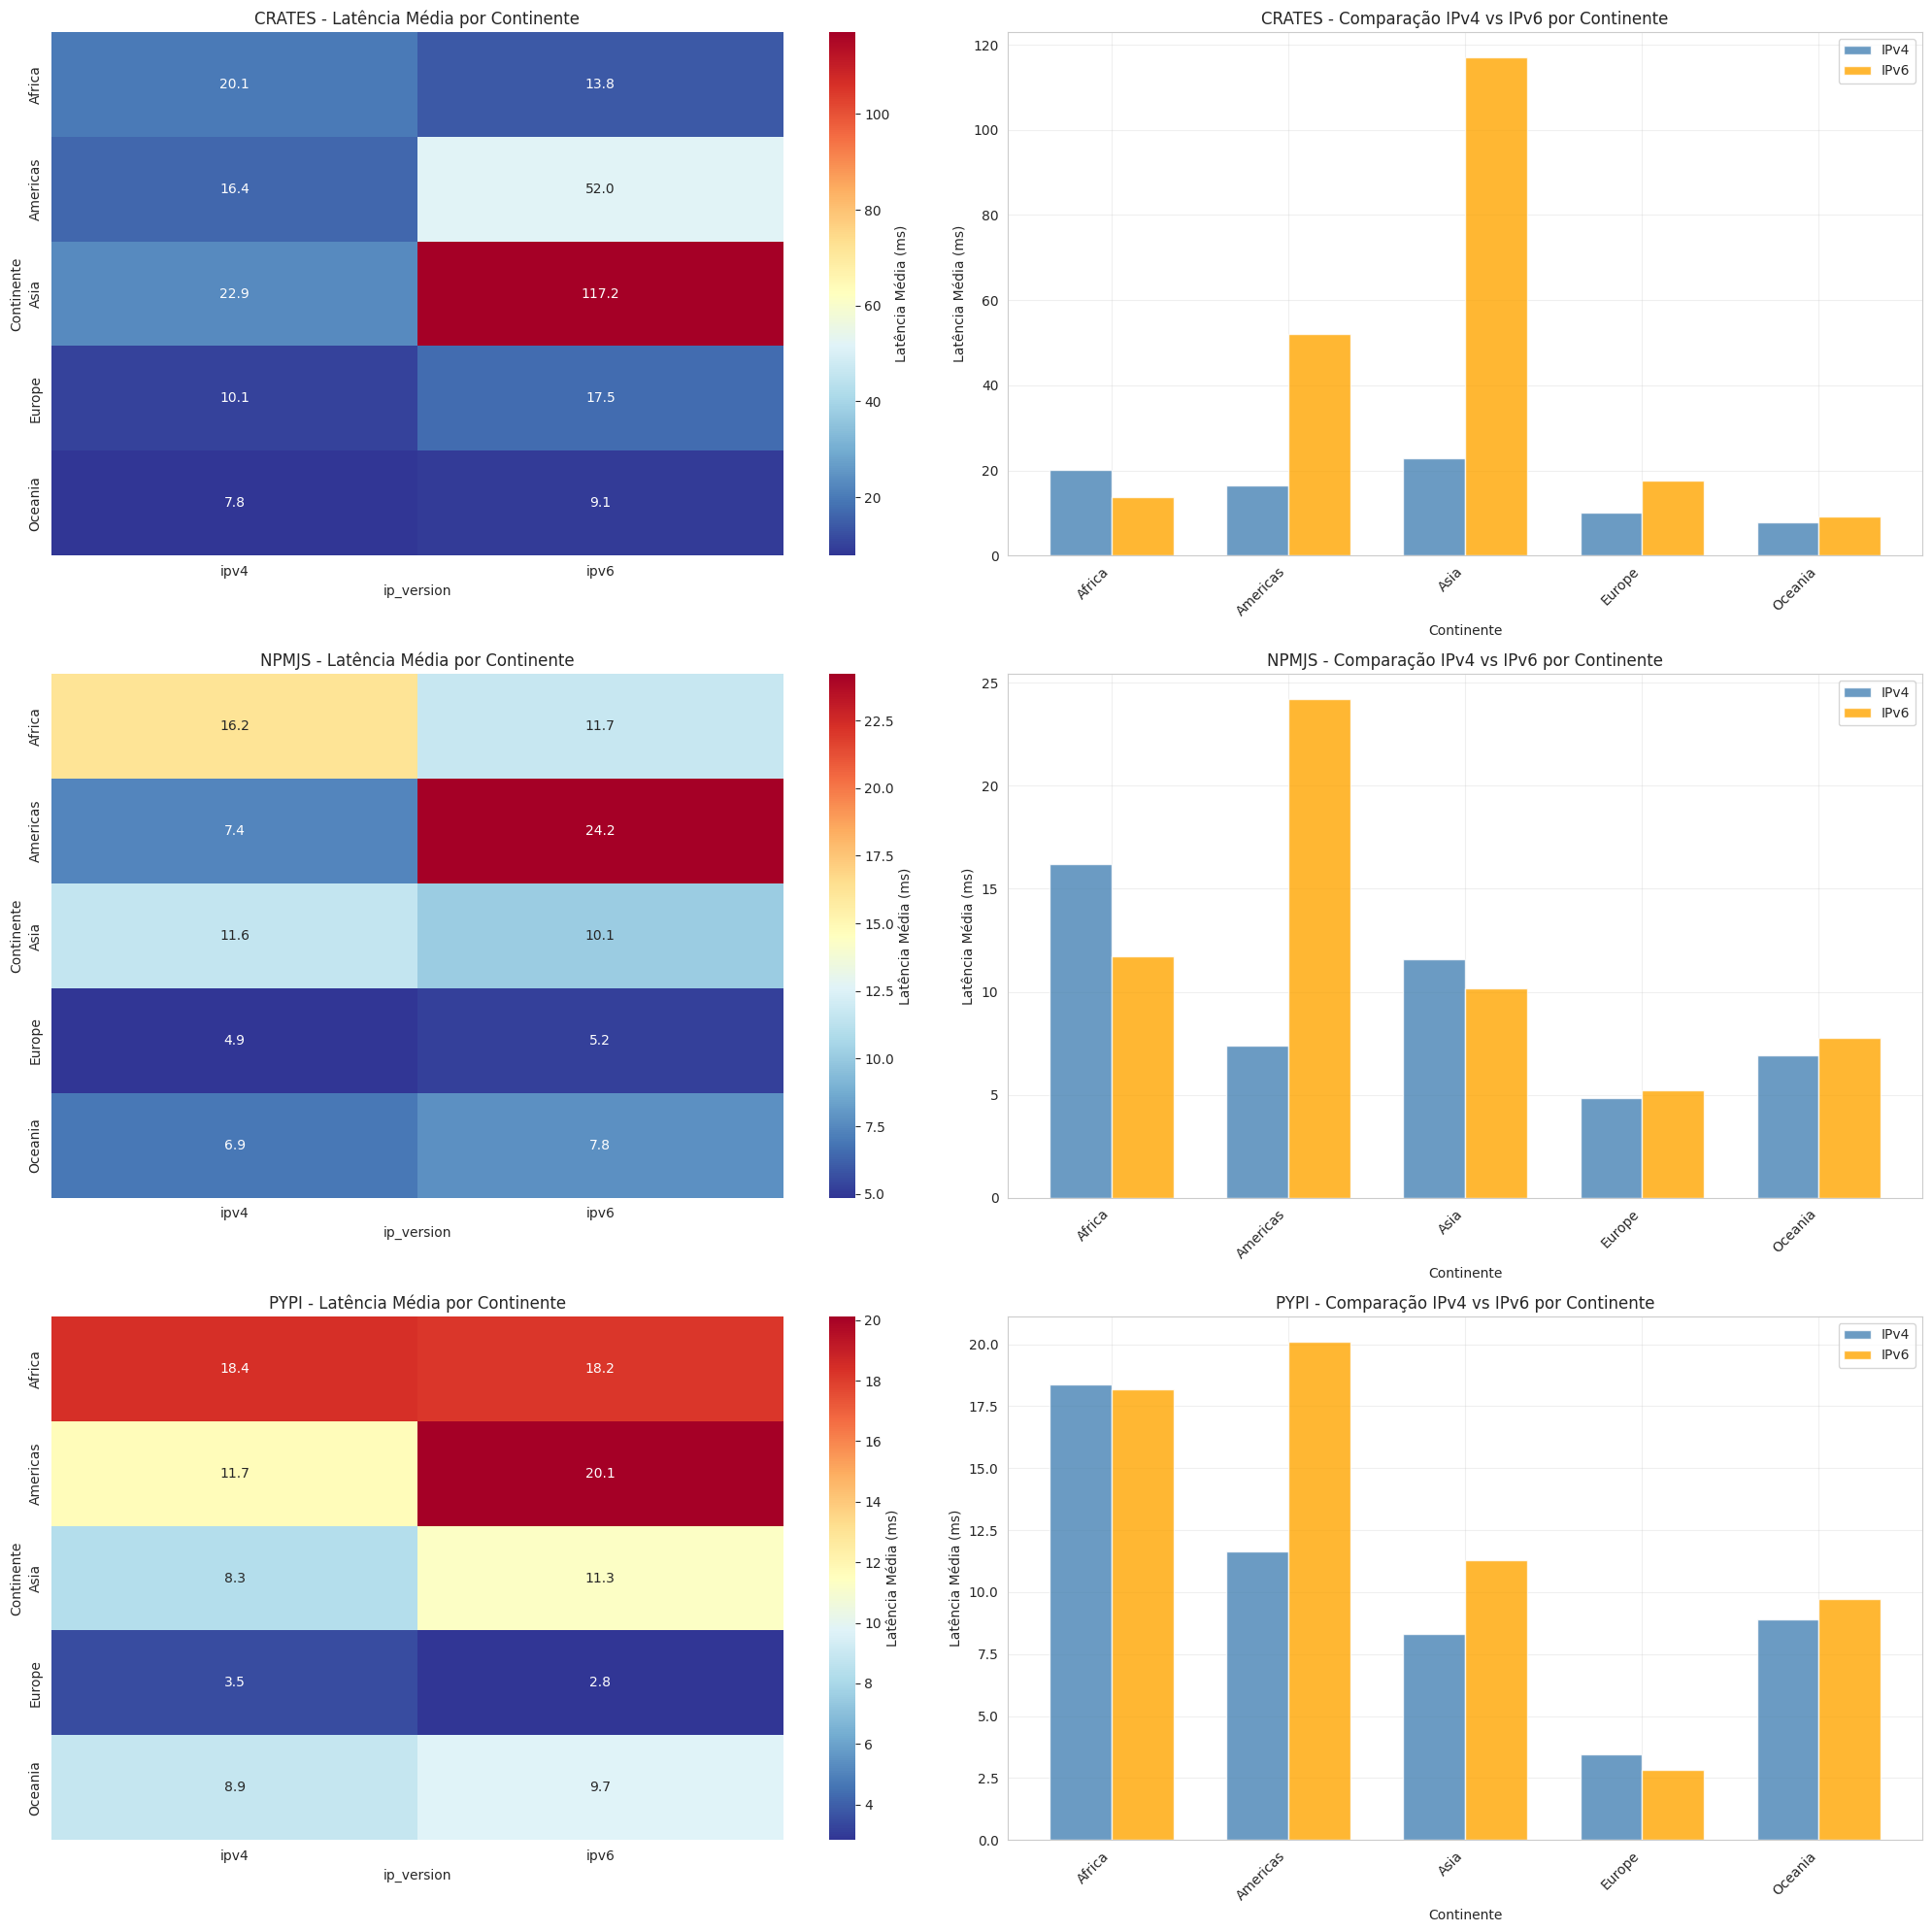

Análise de Latência por Continente:

CRATES:
IPv4:
  Oceania: 7.8ms (±4.8)
  Europe: 10.1ms (±8.0)
  Americas: 16.4ms (±16.6)
  Africa: 20.1ms (±13.5)
  Asia: 22.9ms (±57.7)
IPv6:
  Oceania: 9.1ms (±5.2)
  Africa: 13.8ms (±7.0)
  Europe: 17.5ms (±24.0)
  Americas: 52.0ms (±64.6)
  Asia: 117.2ms (±388.5)

NPMJS:
IPv4:
  Europe: 4.9ms (±3.0)
  Oceania: 6.9ms (±4.1)
  Americas: 7.4ms (±7.3)
  Asia: 11.6ms (±11.1)
  Africa: 16.2ms (±16.0)
IPv6:
  Europe: 5.2ms (±3.5)
  Oceania: 7.8ms (±4.3)
  Asia: 10.1ms (±10.3)
  Africa: 11.7ms (±5.5)
  Americas: 24.2ms (±25.0)

PYPI:
IPv4:
  Europe: 3.5ms (±2.9)
  Asia: 8.3ms (±6.5)
  Oceania: 8.9ms (±8.4)
  Americas: 11.7ms (±10.0)
  Africa: 18.4ms (±18.4)
IPv6:
  Europe: 2.8ms (±2.2)
  Oceania: 9.7ms (±6.4)
  Asia: 11.3ms (±13.9)
  Africa: 18.2ms (±15.6)
  Americas: 20.1ms (±18.6)


In [37]:
# Análise Agregada por Continente - Estilo t.ipynb
# Calculate average latency by continent and IP version
continent_data = combined_df.dropna(subset=['continent'])
continent_latency = continent_data.groupby(['continent', 'ip_version', 'service'])['avg_rtt'].agg(['mean', 'std', 'count']).reset_index()

plt.figure(figsize=(20, 20))

# Create visualizations for each service
for i, service in enumerate(services):
    # Heatmap
    plt.subplot(3, 2, i*2 + 1)
    
    service_data = continent_latency[continent_latency['service'] == service]
    pivot_data = service_data.pivot(index='continent', columns='ip_version', values='mean')
    
    sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='RdYlBu_r', 
                cbar_kws={'label': 'Latência Média (ms)'})
    plt.title(f'{service.upper()} - Latência Média por Continente')
    plt.ylabel('Continente')
    
    # Bar plot comparison
    plt.subplot(3, 2, i*2 + 2)
    
    continents = service_data['continent'].unique()
    ipv4_values = []
    ipv6_values = []
    
    for continent in continents:
        ipv4_val = service_data[(service_data['continent'] == continent) & 
                               (service_data['ip_version'] == 'ipv4')]['mean'].values
        ipv6_val = service_data[(service_data['continent'] == continent) & 
                               (service_data['ip_version'] == 'ipv6')]['mean'].values
        
        ipv4_values.append(ipv4_val[0] if len(ipv4_val) > 0 else 0)
        ipv6_values.append(ipv6_val[0] if len(ipv6_val) > 0 else 0)
    
    x = np.arange(len(continents))
    width = 0.35
    
    plt.bar(x - width/2, ipv4_values, width, label='IPv4', alpha=0.8, color='steelblue')
    plt.bar(x + width/2, ipv6_values, width, label='IPv6', alpha=0.8, color='orange')
    
    plt.xlabel('Continente')
    plt.ylabel('Latência Média (ms)')
    plt.title(f'{service.upper()} - Comparação IPv4 vs IPv6 por Continente')
    plt.xticks(x, continents, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics by continent - Estilo t.ipynb
print("Análise de Latência por Continente:")
print("="*50)

for service in services:
    print(f"\n{service.upper()}:")
    service_data = continent_latency[continent_latency['service'] == service]
    
    print("IPv4:")
    ipv4_data = service_data[service_data['ip_version'] == 'ipv4'].sort_values('mean')
    for _, row in ipv4_data.iterrows():
        print(f"  {row['continent']}: {row['mean']:.1f}ms (±{row['std']:.1f})")
    
    print("IPv6:")
    ipv6_data = service_data[service_data['ip_version'] == 'ipv6'].sort_values('mean')
    for _, row in ipv6_data.iterrows():
        print(f"  {row['continent']}: {row['mean']:.1f}ms (±{row['std']:.1f})")

## 3. Análise de Número de Saltos

### 3.1 Variação do Número de Saltos ao Longo do Tempo

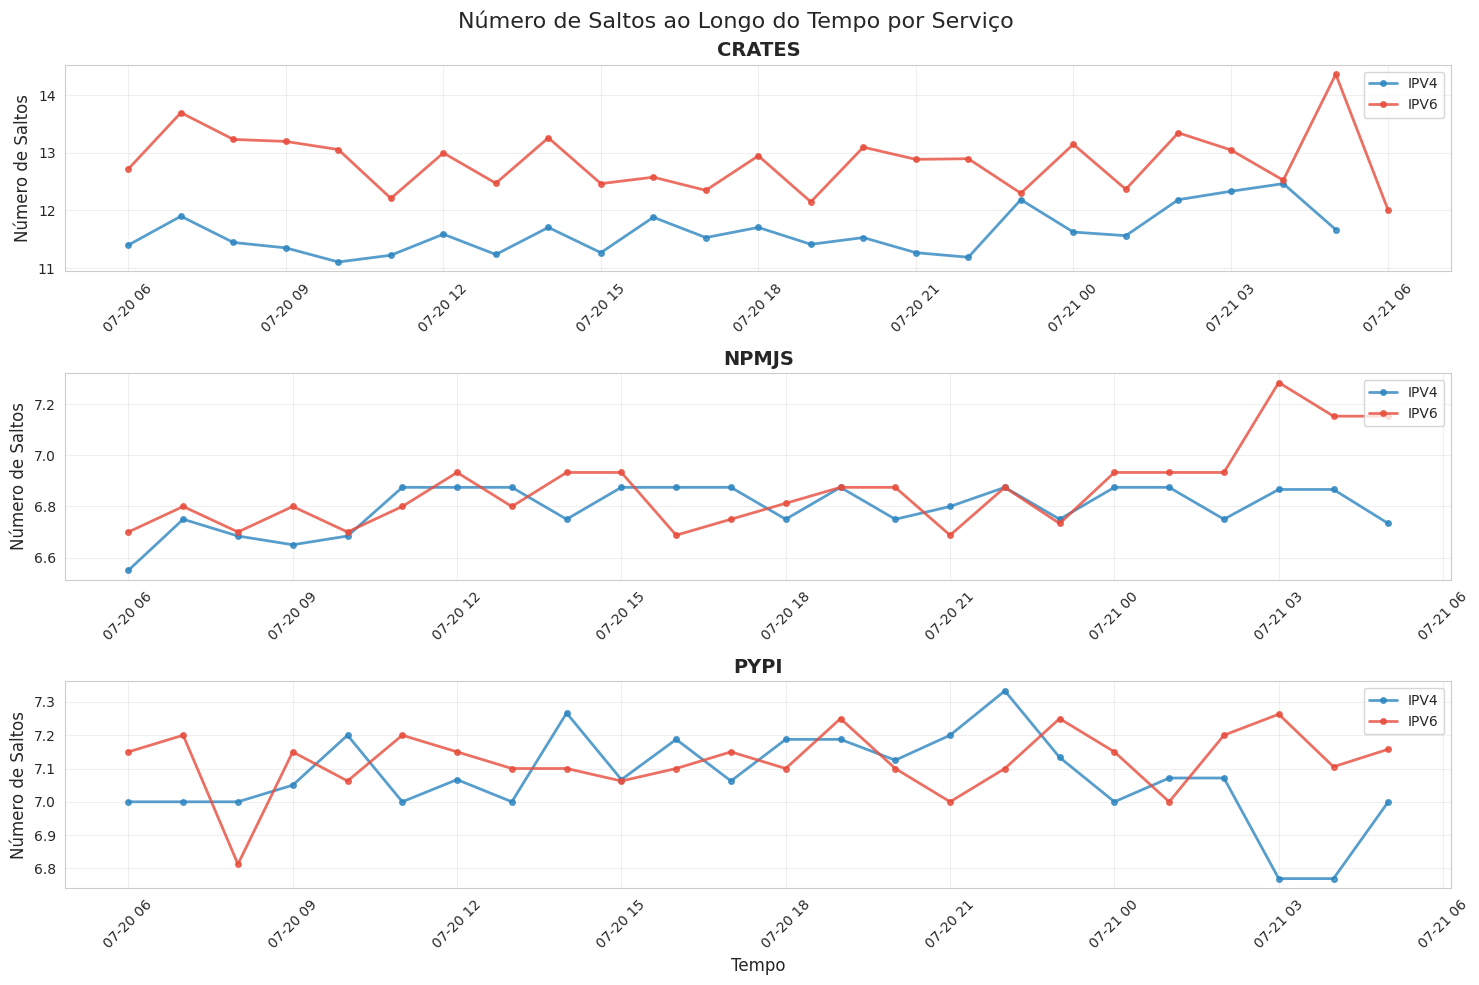

=== RESUMO DE SALTOS POR SERVIÇO ===

CRATES:
  IPV4: 11.6 saltos (±2.4)
  IPV6: 12.9 saltos (±3.2)

NPMJS:
  IPV4: 6.8 saltos (±2.0)
  IPV6: 6.9 saltos (±2.5)

PYPI:
  IPV4: 7.1 saltos (±2.2)
  IPV6: 7.1 saltos (±2.1)


In [38]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
fig.suptitle('Número de Saltos ao Longo do Tempo por Serviço', fontsize=16)

colors = ['#2E86C1', '#E74C3C']  # Blue for IPv4, Red for IPv6

for i, service in enumerate(services):
    service_data = combined_df[combined_df['service'] == service]
    
    # Group by IP version and calculate hourly averages to reduce noise
    service_data_clean = service_data.copy()
    service_data_clean['hour'] = service_data_clean['datetime'].dt.floor('H')
    hourly_avg = service_data_clean.groupby(['hour', 'ip_version'])['hop_count'].mean().reset_index()
    
    # Plot with cleaner style
    for j, ip_version in enumerate(['ipv4', 'ipv6']):
        version_data = hourly_avg[hourly_avg['ip_version'] == ip_version]
        axes[i].plot(version_data['hour'], version_data['hop_count'], 
                    color=colors[j], linewidth=2, marker='o', markersize=4,
                    label=ip_version.upper(), alpha=0.8)
    
    axes[i].set_title(f'{service.upper()}', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Número de Saltos', fontsize=12)
    axes[i].legend(loc='upper right')
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

axes[-1].set_xlabel('Tempo', fontsize=12)
plt.tight_layout()
plt.show()

# Simplified summary statistics
print("=== RESUMO DE SALTOS POR SERVIÇO ===")
for service in services:
    service_data = combined_df[combined_df['service'] == service]
    print(f"\n{service.upper()}:")
    
    for ip_version in ['ipv4', 'ipv6']:
        data = service_data[service_data['ip_version'] == ip_version]['hop_count']
        if not data.empty:
            print(f"  {ip_version.upper()}: {data.mean():.1f} saltos (±{data.std():.1f})")

### 3.2 Comparação de Saltos IPv4 vs IPv6

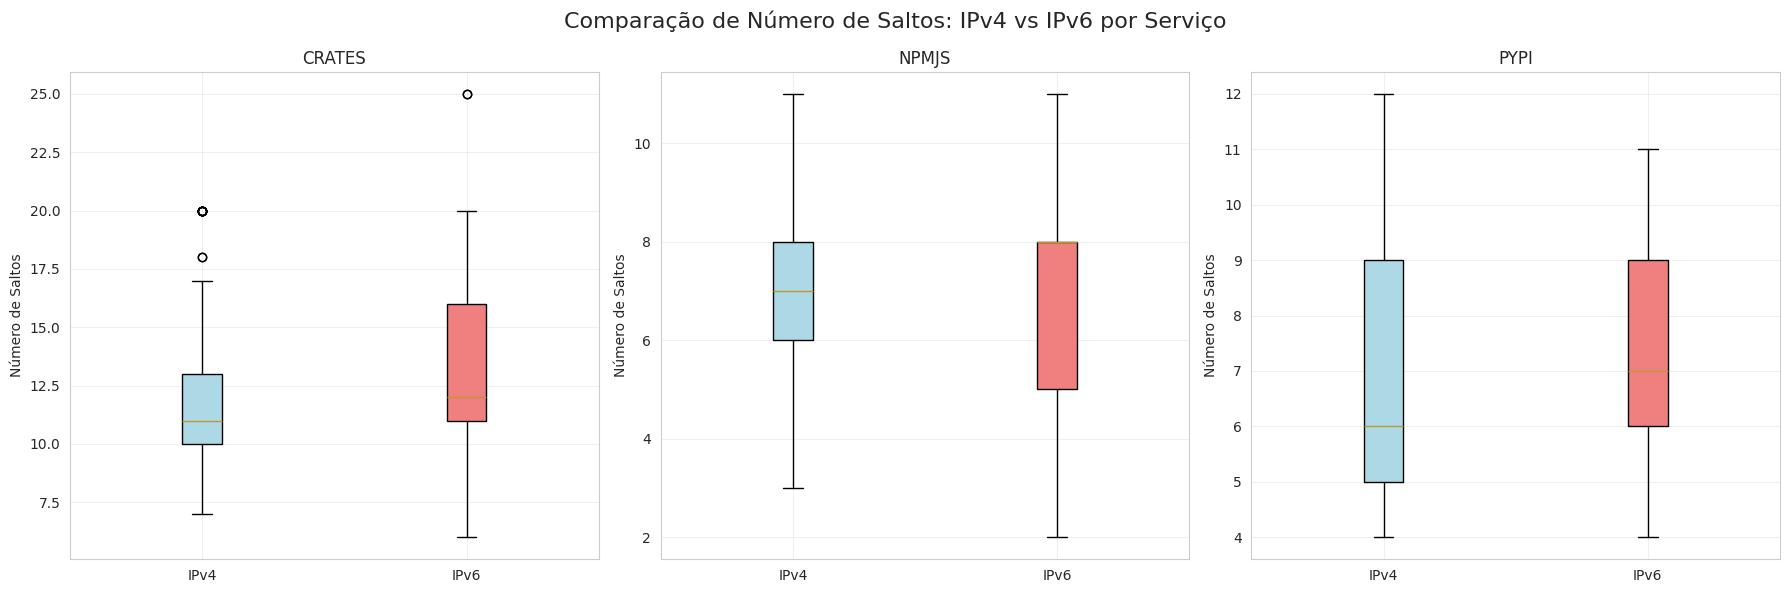

Estatísticas de Número de Saltos por Serviço e Versão IP:

CRATES:
IPv4 - Média: 11.60 saltos, Mediana: 11.00 saltos
IPv6 - Média: 12.89 saltos, Mediana: 12.00 saltos
Diferença percentual (IPv6 vs IPv4): +11.1%

NPMJS:
IPv4 - Média: 6.79 saltos, Mediana: 7.00 saltos
IPv6 - Média: 6.85 saltos, Mediana: 8.00 saltos
Diferença percentual (IPv6 vs IPv4): +0.9%

PYPI:
IPv4 - Média: 7.08 saltos, Mediana: 6.00 saltos
IPv6 - Média: 7.13 saltos, Mediana: 7.00 saltos
Diferença percentual (IPv6 vs IPv4): +0.7%


In [39]:
# Comparação de Saltos IPv4 vs IPv6 Direct Comparison - Estilo t.ipynb
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Comparação de Número de Saltos: IPv4 vs IPv6 por Serviço', fontsize=16)

for i, service in enumerate(services):
    service_data = combined_df[combined_df['service'] == service]
    
    # Create box plots comparing IPv4 vs IPv6
    ipv4_hops = service_data[service_data['ip_version'] == 'ipv4']['hop_count'].dropna()
    ipv6_hops = service_data[service_data['ip_version'] == 'ipv6']['hop_count'].dropna()
    
    box_data = [ipv4_hops, ipv6_hops]
    labels = ['IPv4', 'IPv6']
    
    bp = axes[i].boxplot(box_data, labels=labels, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    axes[i].set_title(f'{service.upper()}')
    axes[i].set_ylabel('Número de Saltos')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical comparison - Estilo t.ipynb
print("Estatísticas de Número de Saltos por Serviço e Versão IP:")
print("="*60)

for service in services:
    print(f"\n{service.upper()}:")
    service_data = combined_df[combined_df['service'] == service]
    
    ipv4_stats = service_data[service_data['ip_version'] == 'ipv4']['hop_count'].describe()
    ipv6_stats = service_data[service_data['ip_version'] == 'ipv6']['hop_count'].describe()
    
    print(f"IPv4 - Média: {ipv4_stats['mean']:.2f} saltos, Mediana: {ipv4_stats['50%']:.2f} saltos")
    print(f"IPv6 - Média: {ipv6_stats['mean']:.2f} saltos, Mediana: {ipv6_stats['50%']:.2f} saltos")
    
    # Calculate percentage difference
    if ipv4_stats['mean'] > 0:
        diff_pct = ((ipv6_stats['mean'] - ipv4_stats['mean']) / ipv4_stats['mean']) * 100
        print(f"Diferença percentual (IPv6 vs IPv4): {diff_pct:+.1f}%")

### 3.3 Saltos por País e Continente

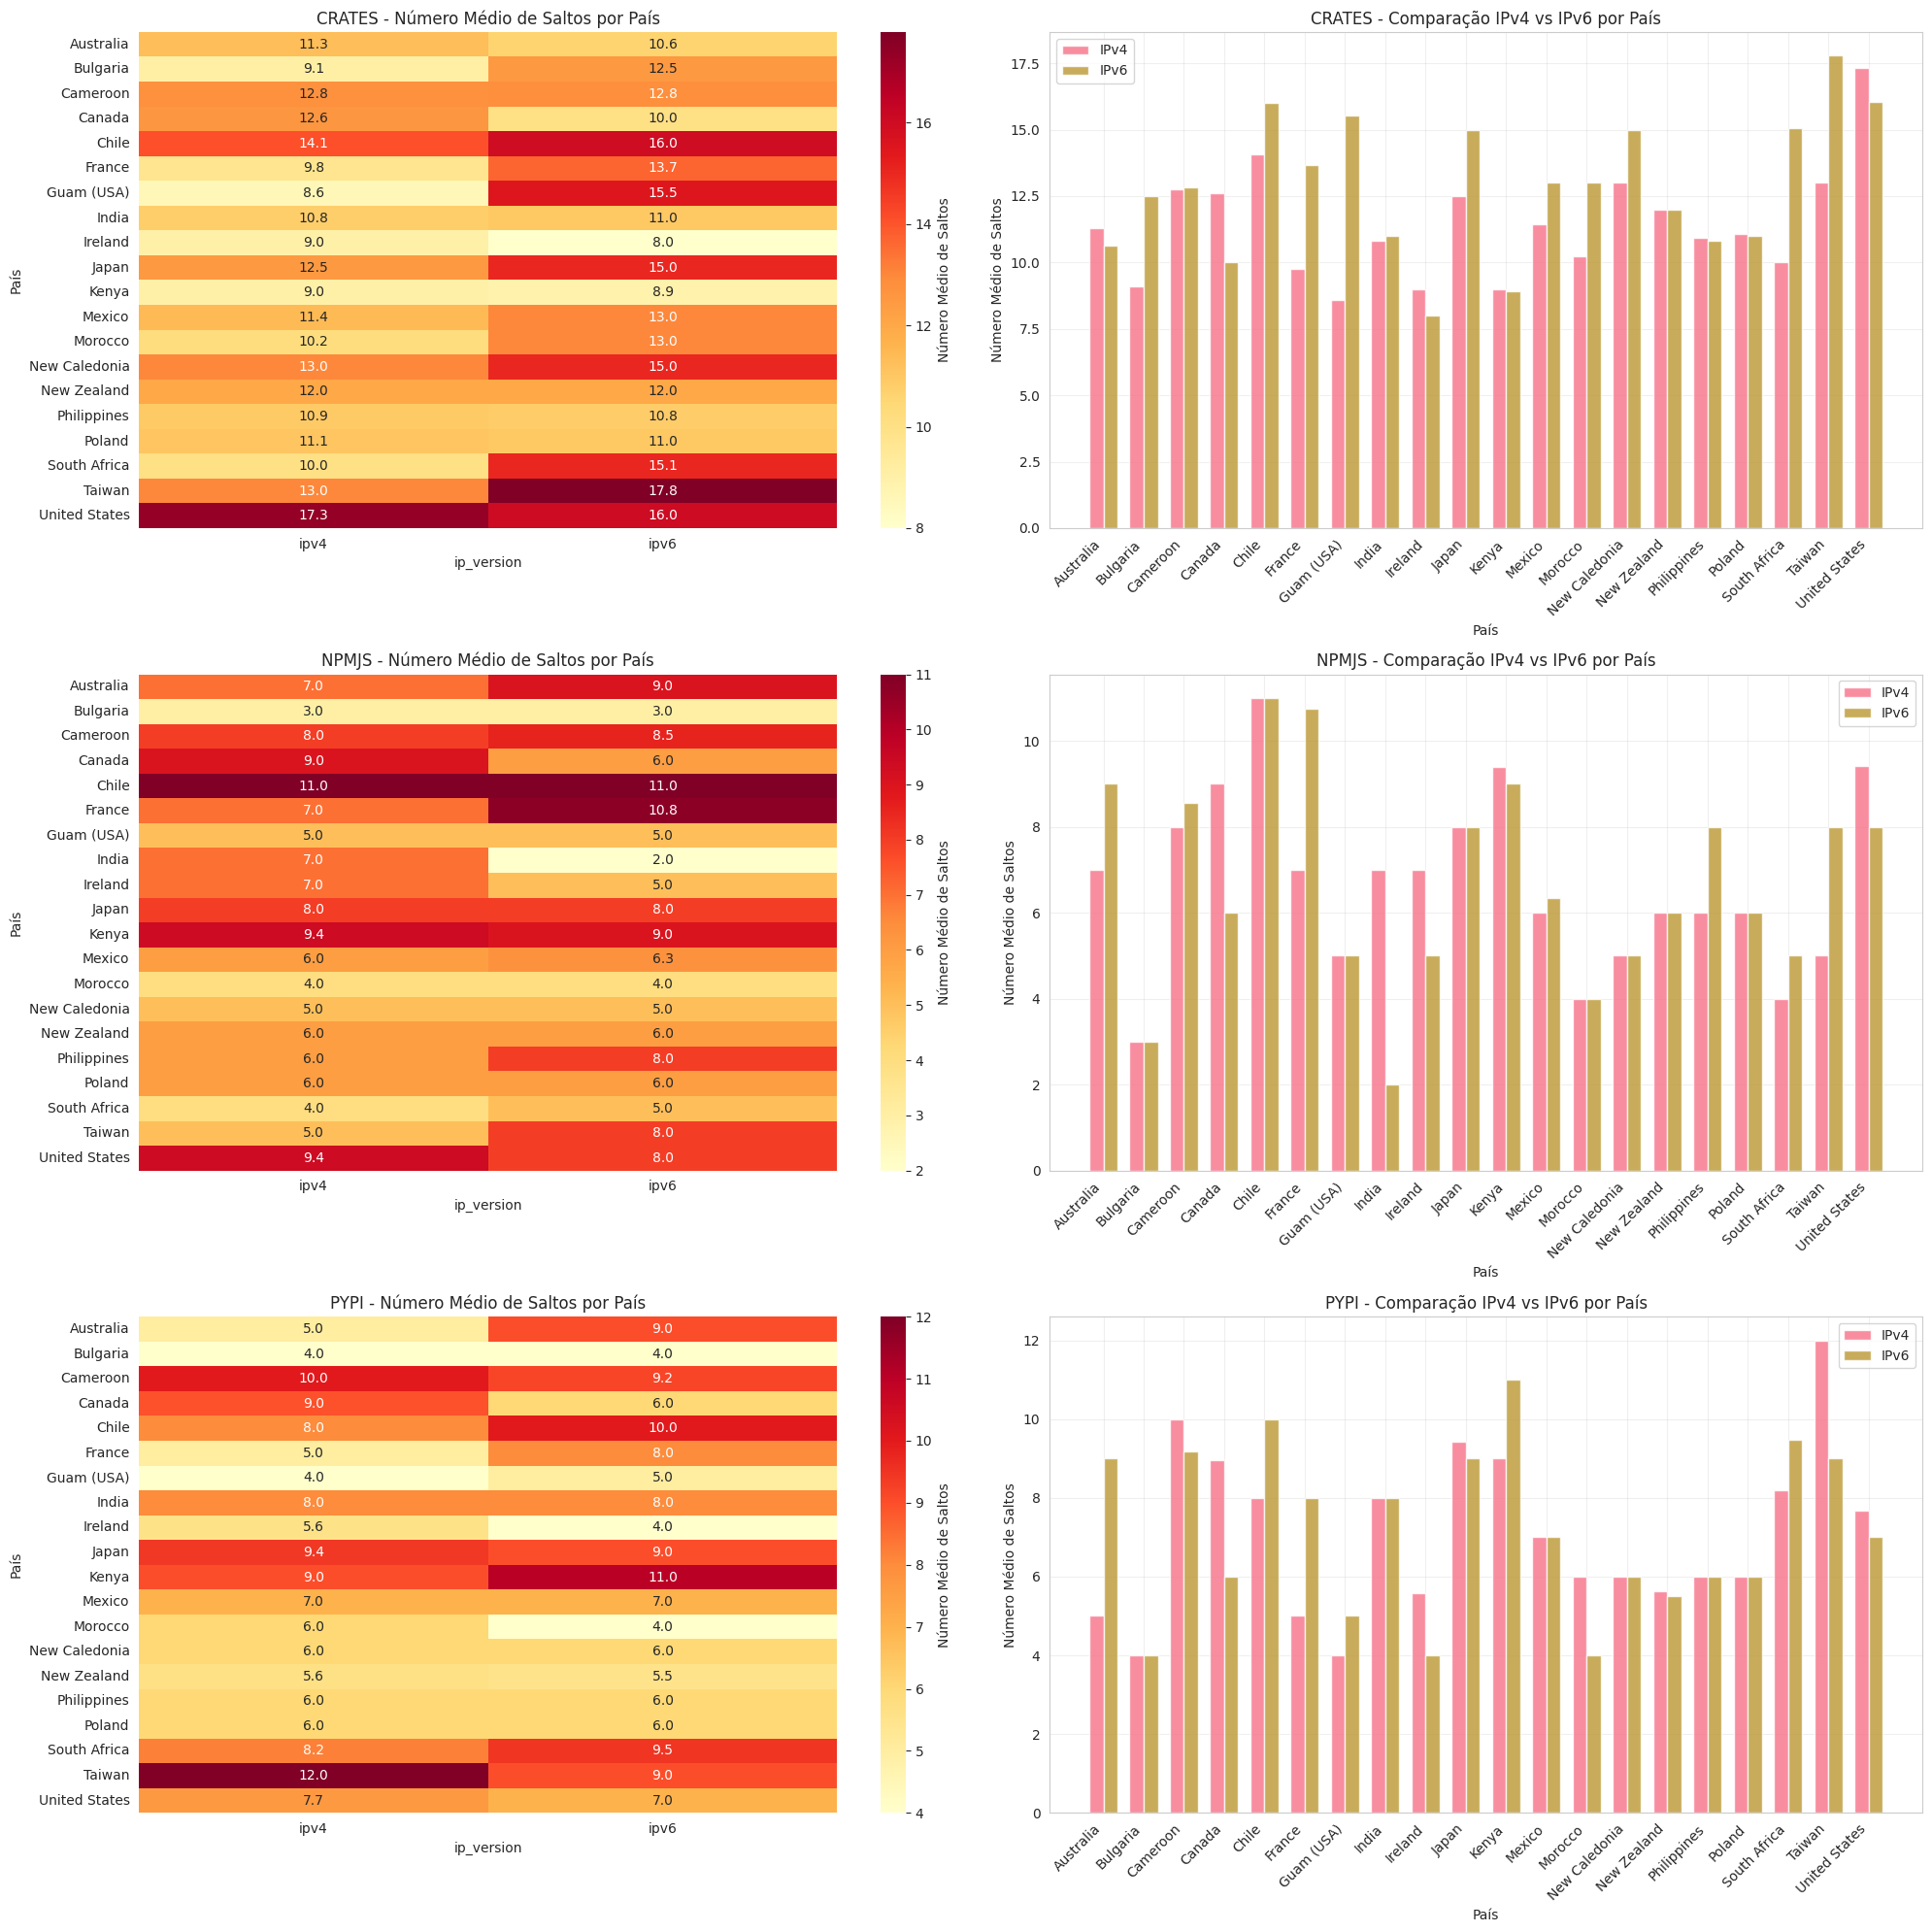

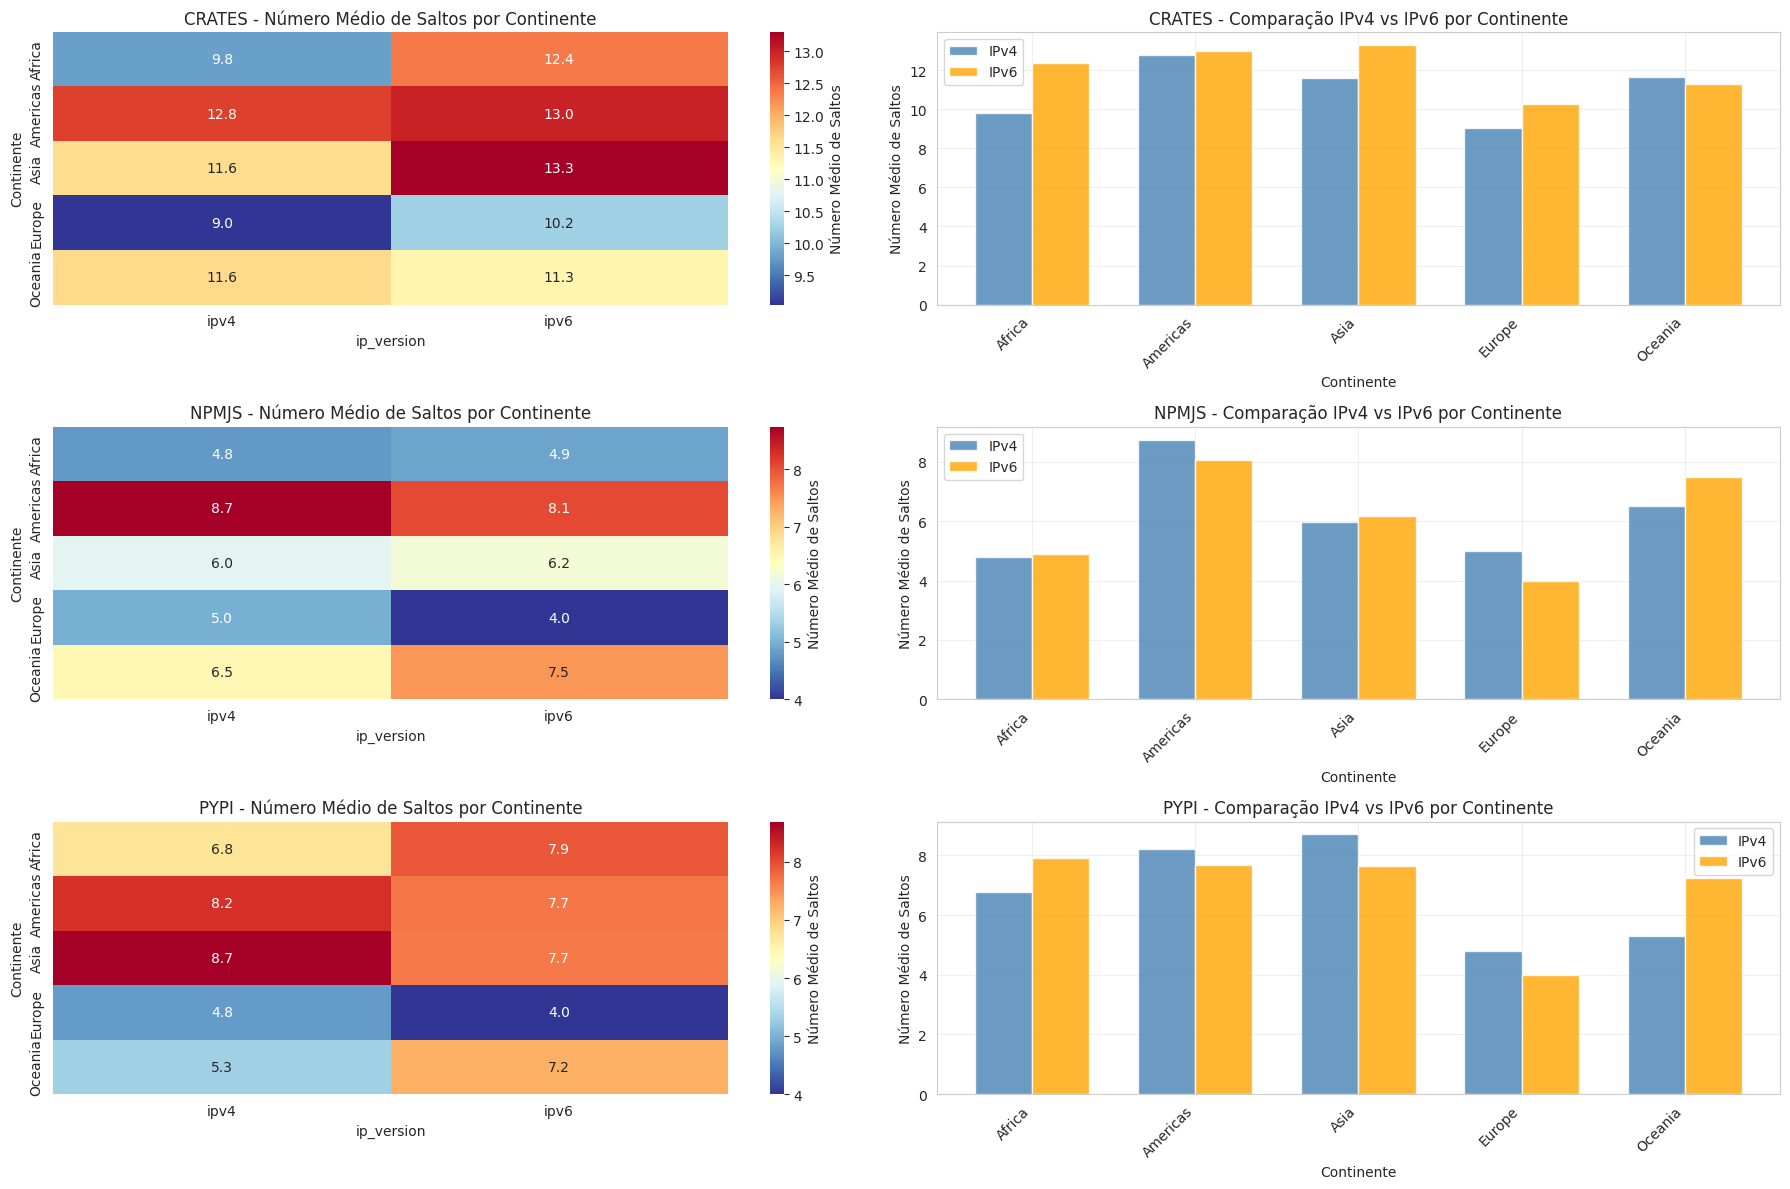

Análise de Saltos por País:

CRATES:
IPv4 - Menos saltos: Guam (USA) (8.6 saltos)
IPv4 - Mais saltos: United States (17.3 saltos)
IPv6 - Menos saltos: Ireland (8.0 saltos)
IPv6 - Mais saltos: Taiwan (17.8 saltos)

NPMJS:
IPv4 - Menos saltos: Bulgaria (3.0 saltos)
IPv4 - Mais saltos: Chile (11.0 saltos)
IPv6 - Menos saltos: India (2.0 saltos)
IPv6 - Mais saltos: Chile (11.0 saltos)

PYPI:
IPv4 - Menos saltos: Bulgaria (4.0 saltos)
IPv4 - Mais saltos: Taiwan (12.0 saltos)
IPv6 - Menos saltos: Bulgaria (4.0 saltos)
IPv6 - Mais saltos: Kenya (11.0 saltos)

Análise de Saltos por Continente:

CRATES:
IPv4:
  Europe: 9.0 saltos (±0.8)
  Africa: 9.8 saltos (±0.9)
  Asia: 11.6 saltos (±1.1)
  Oceania: 11.6 saltos (±1.3)
  Americas: 12.8 saltos (±1.7)
IPv6:
  Europe: 10.2 saltos (±2.6)
  Oceania: 11.3 saltos (±1.9)
  Africa: 12.4 saltos (±2.8)
  Americas: 13.0 saltos (±2.7)
  Asia: 13.3 saltos (±3.4)

NPMJS:
IPv4:
  Africa: 4.8 saltos (±2.0)
  Europe: 5.0 saltos (±2.0)
  Asia: 6.0 saltos (±0.8)


In [40]:
# Análise de Saltos por País e Continente - Estilo t.ipynb
# Calculate average hop count by country and IP version
country_hops = combined_df.groupby(['country', 'ip_version', 'service'])['hop_count'].agg(['mean', 'std', 'count']).reset_index()

plt.figure(figsize=(20, 20))

# Create heatmap for each service
for i, service in enumerate(services):
    plt.subplot(3, 2, i*2 + 1)
    
    service_data = country_hops[country_hops['service'] == service]
    pivot_data = service_data.pivot(index='country', columns='ip_version', values='mean')
    
    sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='YlOrRd', 
                cbar_kws={'label': 'Número Médio de Saltos'})
    plt.title(f'{service.upper()} - Número Médio de Saltos por País')
    plt.ylabel('País')
    
    # Bar plot comparison
    plt.subplot(3, 2, i*2 + 2)
    
    # Prepare data for grouped bar plot
    countries = service_data['country'].unique()
    ipv4_values = []
    ipv6_values = []
    
    for country in countries:
        ipv4_val = service_data[(service_data['country'] == country) & 
                               (service_data['ip_version'] == 'ipv4')]['mean'].values
        ipv6_val = service_data[(service_data['country'] == country) & 
                               (service_data['ip_version'] == 'ipv6')]['mean'].values
        
        ipv4_values.append(ipv4_val[0] if len(ipv4_val) > 0 else 0)
        ipv6_values.append(ipv6_val[0] if len(ipv6_val) > 0 else 0)
    
    x = np.arange(len(countries))
    width = 0.35
    
    plt.bar(x - width/2, ipv4_values, width, label='IPv4', alpha=0.8)
    plt.bar(x + width/2, ipv6_values, width, label='IPv6', alpha=0.8)
    
    plt.xlabel('País')
    plt.ylabel('Número Médio de Saltos')
    plt.title(f'{service.upper()} - Comparação IPv4 vs IPv6 por País')
    plt.xticks(x, countries, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Saltos por continente - Estilo t.ipynb
continent_hops = continent_data.groupby(['continent', 'ip_version', 'service'])['hop_count'].agg(['mean', 'std', 'count']).reset_index()

plt.figure(figsize=(18, 12))

# Create visualizations for each service
for i, service in enumerate(services):
    # Heatmap
    plt.subplot(3, 2, i*2 + 1)
    
    service_data = continent_hops[continent_hops['service'] == service]
    pivot_data = service_data.pivot(index='continent', columns='ip_version', values='mean')
    
    sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='RdYlBu_r', 
                cbar_kws={'label': 'Número Médio de Saltos'})
    plt.title(f'{service.upper()} - Número Médio de Saltos por Continente')
    plt.ylabel('Continente')
    
    # Bar plot comparison
    plt.subplot(3, 2, i*2 + 2)
    
    continents = service_data['continent'].unique()
    ipv4_values = []
    ipv6_values = []
    
    for continent in continents:
        ipv4_val = service_data[(service_data['continent'] == continent) & 
                               (service_data['ip_version'] == 'ipv4')]['mean'].values
        ipv6_val = service_data[(service_data['continent'] == continent) & 
                               (service_data['ip_version'] == 'ipv6')]['mean'].values
        
        ipv4_values.append(ipv4_val[0] if len(ipv4_val) > 0 else 0)
        ipv6_values.append(ipv6_val[0] if len(ipv6_val) > 0 else 0)
    
    x = np.arange(len(continents))
    width = 0.35
    
    plt.bar(x - width/2, ipv4_values, width, label='IPv4', alpha=0.8, color='steelblue')
    plt.bar(x + width/2, ipv6_values, width, label='IPv6', alpha=0.8, color='orange')
    
    plt.xlabel('Continente')
    plt.ylabel('Número Médio de Saltos')
    plt.title(f'{service.upper()} - Comparação IPv4 vs IPv6 por Continente')
    plt.xticks(x, continents, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Análise de Saltos por País:")
print("="*50)

for service in services:
    print(f"\n{service.upper()}:")
    service_data = country_hops[country_hops['service'] == service]
    
    # Best and worst performing countries for IPv4
    ipv4_data = service_data[service_data['ip_version'] == 'ipv4'].sort_values('mean')
    if not ipv4_data.empty:
        print(f"IPv4 - Menos saltos: {ipv4_data.iloc[0]['country']} ({ipv4_data.iloc[0]['mean']:.1f} saltos)")
        print(f"IPv4 - Mais saltos: {ipv4_data.iloc[-1]['country']} ({ipv4_data.iloc[-1]['mean']:.1f} saltos)")
    
    # Best and worst performing countries for IPv6
    ipv6_data = service_data[service_data['ip_version'] == 'ipv6'].sort_values('mean')
    if not ipv6_data.empty:
        print(f"IPv6 - Menos saltos: {ipv6_data.iloc[0]['country']} ({ipv6_data.iloc[0]['mean']:.1f} saltos)")
        print(f"IPv6 - Mais saltos: {ipv6_data.iloc[-1]['country']} ({ipv6_data.iloc[-1]['mean']:.1f} saltos)")

print("\nAnálise de Saltos por Continente:")
print("="*50)

for service in services:
    print(f"\n{service.upper()}:")
    service_data = continent_hops[continent_hops['service'] == service]
    
    print("IPv4:")
    ipv4_data = service_data[service_data['ip_version'] == 'ipv4'].sort_values('mean')
    for _, row in ipv4_data.iterrows():
        print(f"  {row['continent']}: {row['mean']:.1f} saltos (±{row['std']:.1f})")
    
    print("IPv6:")
    ipv6_data = service_data[service_data['ip_version'] == 'ipv6'].sort_values('mean')
    for _, row in ipv6_data.iterrows():
        print(f"  {row['continent']}: {row['mean']:.1f} saltos (±{row['std']:.1f})")

## 4. Correlação entre Latência e Número de Saltos

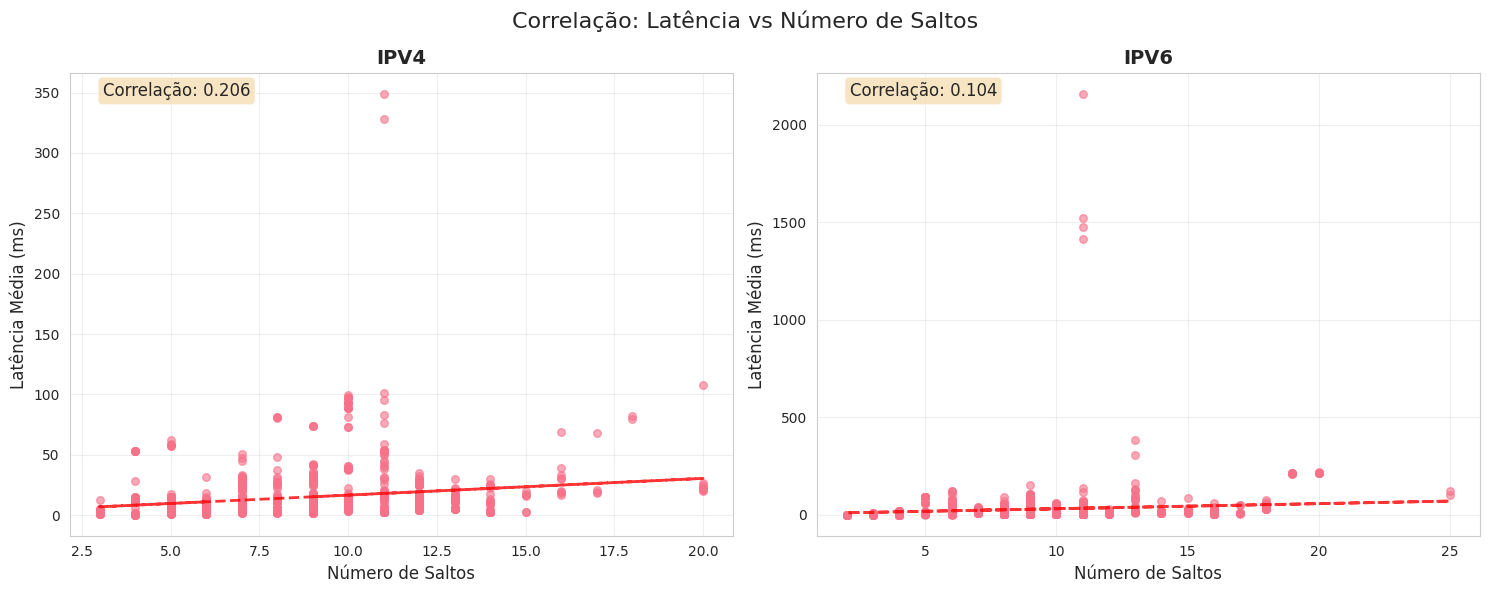

Matriz de Correlação (Latência vs Saltos por versão IP):

IPV4:
           avg_rtt  hop_count
avg_rtt      1.000      0.206
hop_count    0.206      1.000

IPV6:
           avg_rtt  hop_count
avg_rtt      1.000      0.104
hop_count    0.104      1.000


In [41]:
# Correlação entre Latência e Número de Saltos - Estilo t.ipynb
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Correlação: Latência vs Número de Saltos', fontsize=16)

for i, ip_version in enumerate(['ipv4', 'ipv6']):
    data = combined_df[combined_df['ip_version'] == ip_version]
    
    # Scatter plot with seaborn style
    axes[i].scatter(data['hop_count'], data['avg_rtt'], alpha=0.6, s=30)
    
    # Regression line
    if len(data) > 1:
        z = np.polyfit(data['hop_count'], data['avg_rtt'], 1)
        p = np.poly1d(z)
        axes[i].plot(data['hop_count'], p(data['hop_count']), "r--", alpha=0.8, linewidth=2)
        
        # Calculate correlation
        correlation = data['hop_count'].corr(data['avg_rtt'])
        axes[i].text(0.05, 0.95, f'Correlação: {correlation:.3f}', 
                    transform=axes[i].transAxes, fontsize=12,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    axes[i].set_title(f'{ip_version.upper()}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Número de Saltos', fontsize=12)
    axes[i].set_ylabel('Latência Média (ms)', fontsize=12)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Matriz de correlação - Estilo t.ipynb
print("Matriz de Correlação (Latência vs Saltos por versão IP):")
print("="*60)
for ip_version in ['ipv4', 'ipv6']:
    data = combined_df[combined_df['ip_version'] == ip_version]
    corr = data[['avg_rtt', 'hop_count']].corr()
    print(f"\n{ip_version.upper()}:")
    print(corr.round(3))

## 5. Resumo e Conclusões

In [42]:
# Resumo estatístico final
print("=" * 60)
print("RESUMO EXECUTIVO - ANÁLISE IPv4 vs IPv6")
print("=" * 60)

# Estatísticas gerais
print("\n1. ESTATÍSTICAS GERAIS:")
print(f"   - Total de medições: {len(combined_df):,}")
print(f"   - Período analisado: {combined_df['datetime'].min()} a {combined_df['datetime'].max()}")
print(f"   - Países analisados: {combined_df['country'].nunique()}")
print(f"   - Continentes: {combined_df['continent'].nunique()}")
print(f"   - Serviços: {', '.join(combined_df['service'].unique())}")

# Comparação IPv4 vs IPv6 - Latência
print("\n2. LATÊNCIA - IPv4 vs IPv6:")
for service in combined_df['service'].unique():
    print(f"\n   {service.upper()}:")
    service_data = combined_df[combined_df['service'] == service]
    
    ipv4_latency = service_data[service_data['ip_version'] == 'ipv4']['avg_rtt']
    ipv6_latency = service_data[service_data['ip_version'] == 'ipv6']['avg_rtt']
    
    if not ipv4_latency.empty and not ipv6_latency.empty:
        print(f"     IPv4: {ipv4_latency.mean():.2f}ms ± {ipv4_latency.std():.2f}ms")
        print(f"     IPv6: {ipv6_latency.mean():.2f}ms ± {ipv6_latency.std():.2f}ms")
        diff = ipv6_latency.mean() - ipv4_latency.mean()
        print(f"     Diferença: {diff:.2f}ms ({diff/ipv4_latency.mean()*100:.1f}%)")

# Comparação IPv4 vs IPv6 - Saltos
print("\n3. NÚMERO DE SALTOS - IPv4 vs IPv6:")
for service in combined_df['service'].unique():
    print(f"\n   {service.upper()}:")
    service_data = combined_df[combined_df['service'] == service]
    
    ipv4_hops = service_data[service_data['ip_version'] == 'ipv4']['hop_count']
    ipv6_hops = service_data[service_data['ip_version'] == 'ipv6']['hop_count']
    
    if not ipv4_hops.empty and not ipv6_hops.empty:
        print(f"     IPv4: {ipv4_hops.mean():.1f} saltos ± {ipv4_hops.std():.1f}")
        print(f"     IPv6: {ipv6_hops.mean():.1f} saltos ± {ipv6_hops.std():.1f}")
        diff = ipv6_hops.mean() - ipv4_hops.mean()
        print(f"     Diferença: {diff:.1f} saltos")

# Análise por continente
print("\n4. ANÁLISE POR CONTINENTE (Latência Média):")
continent_summary = continent_data.groupby(['continent', 'ip_version'])['avg_rtt'].mean().unstack()
for continent in continent_summary.index:
    ipv4_lat = continent_summary.loc[continent, 'ipv4'] if 'ipv4' in continent_summary.columns else np.nan
    ipv6_lat = continent_summary.loc[continent, 'ipv6'] if 'ipv6' in continent_summary.columns else np.nan
    
    print(f"\n   {continent}:")
    if not pd.isna(ipv4_lat):
        print(f"     IPv4: {ipv4_lat:.2f}ms")
    if not pd.isna(ipv6_lat):
        print(f"     IPv6: {ipv6_lat:.2f}ms")
    if not pd.isna(ipv4_lat) and not pd.isna(ipv6_lat):
        diff = ipv6_lat - ipv4_lat
        print(f"     Diferença: {diff:.2f}ms")


RESUMO EXECUTIVO - ANÁLISE IPv4 vs IPv6

1. ESTATÍSTICAS GERAIS:
   - Total de medições: 2,492
   - Período analisado: 2025-07-20 06:00:26 a 2025-07-21 06:00:34
   - Países analisados: 20
   - Continentes: 5
   - Serviços: crates, npmjs, pypi

2. LATÊNCIA - IPv4 vs IPv6:

   CRATES:
     IPv4: 17.30ms ± 27.64ms
     IPv6: 43.04ms ± 159.35ms
     Diferença: 25.74ms (148.7%)

   NPMJS:
     IPv4: 10.58ms ± 10.19ms
     IPv6: 17.61ms ± 23.14ms
     Diferença: 7.03ms (66.4%)

   PYPI:
     IPv4: 15.73ms ± 20.42ms
     IPv6: 22.97ms ± 25.18ms
     Diferença: 7.24ms (46.0%)

3. NÚMERO DE SALTOS - IPv4 vs IPv6:

   CRATES:
     IPv4: 11.6 saltos ± 2.4
     IPv6: 12.9 saltos ± 3.2
     Diferença: 1.3 saltos

   NPMJS:
     IPv4: 6.8 saltos ± 2.0
     IPv6: 6.9 saltos ± 2.5
     Diferença: 0.1 saltos

   PYPI:
     IPv4: 7.1 saltos ± 2.2
     IPv6: 7.1 saltos ± 2.1
     Diferença: 0.0 saltos

4. ANÁLISE POR CONTINENTE (Latência Média):

   Africa:
     IPv4: 18.41ms
     IPv6: 15.11ms
     Dife